In [1]:
from IPython.display import display, clear_output
import numpy as np
from nptdms import TdmsFile
import matplotlib.pyplot as plt
import ipywidgets as ipw
import os
import trackpy as tp
from ipywidgets import interact
import ipywidgets as widgets
from PIL import Image
from torchvision import transforms

In [2]:
f=TdmsFile.read("Clustering video.tdms")

In [3]:
f['Image']['Image'].data.size   

243269632

In [4]:
class TDMS_Video:
    def __init__(self, filename):
        self.tdms_file = TdmsFile.read(filename)
        self.props = dict(self.tdms_file.properties)
        self.dimx = int(self.props["dimx"])
        self.dimy = int(self.props["dimy"])
        self.frames = 1108#int(self.props["frames"])
        self.image_group = self.tdms_file['Image']
        self.image_channel = self.image_group['Image']
        self.frames=int(self.image_channel.data.size/self.dimx/self.dimy)
        self.images = self.image_channel.data.reshape([self.frames, self.dimx, self.dimy])    

    def get_image(self, image_num):
        return self.images[image_num, :, :]

    def write_images(self, directory_name):
        os.makedirs(directory_name, exist_ok=True)
        for frame in range(self.frames):
            filename = os.path.join(directory_name, f"output_{frame:03}.png")
            plt.imsave(filename, self.images[frame, :, :], cmap="gray")

    def get_particle(self, image_num, pos, size):
        image = self.get_image(image_num)
        xp, yp = map(int, pos)
        xs, xe = max(0, xp - size - 1), xp + size
        ys, ye = max(0, yp - size - 1), yp + size
        return image[xs:xe, ys:ye]

    def loc_particles(self, image_num, dist=31, minmass=1e5, display=False):
        image = self.get_image(image_num)
        f = tp.locate(image, dist, invert=True, minmass=minmass)
        if display:
            tp.annotate(f, image)
        return f

In [5]:
import ipywidgets as widgets

# Get a list of .tdms files in the current directory
files = [f for f in os.listdir() if f.endswith('.tdms')]

class ParticleImages:
    def __init__(self):
        self.images = []
        self.progress = widgets.IntProgress(description='Loading:', min=0, max=1)  # initialize progress bar
        self.output = widgets.Output()  # output widget to display the progress bar

    def on_file_selected(self, change):
        self.images.clear()  # clear any previous images
        file = change['new']
        video = TDMS_Video(file)
        frames = video.frames

        # Update the maximum value and display the progress bar
        self.progress.max = frames
        with self.output:
            clear_output(wait=True)  # clear the previous progress bar
            display(self.progress)

        # Loop over each frame
        for frame in range(frames):
            # Locate particles in the current frame
            particle_image = video.get_image(frame)
            self.images.append(particle_image)


            # Update the progress bar
            self.progress.value = frame + 1

# Create an instance of ParticleImages
particle_images = ParticleImages()

dropdown = widgets.Dropdown(options=files, description='Select file:')
dropdown.observe(particle_images.on_file_selected, names='value')

box = widgets.VBox([dropdown, particle_images.output])
display(box)

In [6]:
file=TDMS_Video("Clustering1 video.tdms")

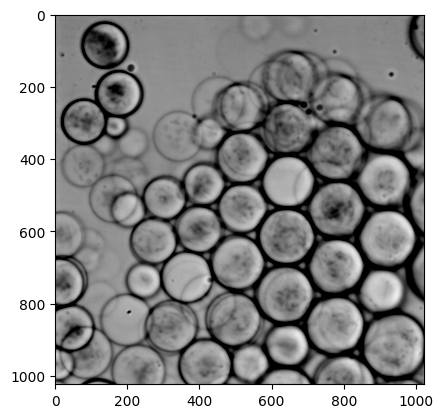

In [78]:
plt.imshow(np.log(file.images.sum(axis=0)),cmap="gray",vmin=15.3,vmax=15.9)

In [7]:
def browse_images(images):
    n = len(images)
    def view_image(i):
        plt.imshow(images[i], cmap='gray')
        plt.show()
    interact(view_image, i=(0,n-1))

browse_images(file.images)

interactive(children=(IntSlider(value=295, description='i', max=590), Output()), _dom_classes=('widget-interac…

In [45]:
 plt.imsave("droplet.png", file.images[0], cmap="gray")

(-0.5, 1023.5, 1023.5, -0.5)

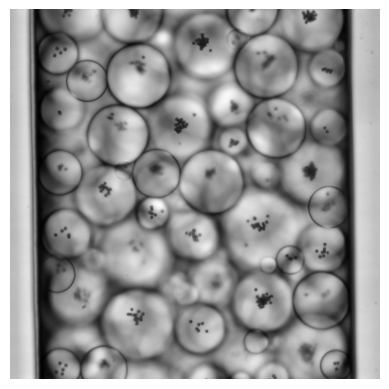

In [25]:
plt.imshow(file.images[0],cmap="gray")
plt.axis("off")

In [7]:
iml=particle_images.images

In [8]:
def browse_images(images):
    n = len(images)
    def view_image(i):
        plt.imshow(images[i], cmap='gray')
        plt.show()
    interact(view_image, i=(0,n-1))

browse_images(iml)

interactive(children=(IntSlider(value=403, description='i', max=806), Output()), _dom_classes=('widget-interac…

In [18]:
img=iml[33]

In [23]:
def write_images(directory_name):
        os.makedirs(directory_name, exist_ok=True)
        for frame in range(100):
            filename = os.path.join(directory_name, f"output_{frame:03}.png")
            plt.imsave(filename, img, cmap="gray")

In [24]:
write_images("JP_Data1")

## Convolutional Neural Network to Learn the Orientation

In [10]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim


In [11]:


# Specify the directory
directory = 'JP_Data'

# Get a list of all file names in the directory
filenames = os.listdir(directory)

# Initialize a list to store the images
images = []

# Loop over the filenames
for filename in filenames:
    # Only read .png files
    if filename.endswith('.png'):
        # Open the image file
        with Image.open(os.path.join(directory, filename)) as img:
            # Convert the image to grayscale
            img_gray = img.convert('L')
            # Convert the grayscale image to a numpy array and append it to the list
            images.append(np.array(img_gray))

# Convert the list of images to a numpy array
images = np.array(images,dtype=np.float32).reshape(100,61,61)

In [12]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.fc1 = nn.Linear(32 * 12 * 12, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 32 * 12 * 12)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [14]:
class ParticleDataset(Dataset):
    def __init__(self, images, rotations):
        self.images = np.array(images,dtype=np.float32)
        self.rotations = rotations
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomRotation(self.rotations),            
            #transforms.Normalize((0.5,), (0.5,)),
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):        
        image = self.images[idx]

        angle = torch.randint(0, 360, size=(1,))
        rotated_img = rotate(img, angle.item())

        
        image = self.transform(image)  # Apply the transformations
        return image

In [15]:
batch_size=10
num_epochs=100

rotations = [0., 90.]  # List of possible rotations
dataset = ParticleDataset(images, rotations)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [17]:
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        inputs = torch.from_numpy(np.array(data,dtype=np.float32))  # convert input tensor to PyTorch tensor
        optimizer.zero_grad()
        outputs = net(inputs)
        print(outputs.shape)
        loss = criterion(outputs, torch.tensor([1]*10, dtype=torch.long))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('Epoch %d loss: %.8f' % (epoch + 1, running_loss / len(dataloader)))

torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
Epoch 1 loss: 19.43428876
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
Epoch 2 loss: 0.00000000
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
Epoch 3 loss: 0.00000000
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
Epoch 4 loss: 0.00000000
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])
torch.Size([10, 4])